# Third generation: sequential trade models

## Introduction




<div class="alert alert-block alert-warning">
    
<b>Note:</b> To re-run this Notebook one needs a S&P500 Emini futures contracts dataset that is not included in the repositry. It can be purchased from TickData LLC. Please check [our documentation](https://mlfinlab.readthedocs.io/en/latest/getting_started/barriers_to_entry.html) for more details.

</div>

> **Underlying Literature**: The following module was inspired by the ideas put forward in Chapter 18 and 19 of [Advances in Financial Machine Learning](https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086) by Marcos Lopez de Prado

Third generation models look at microstructures through the lens of randomly selected traders that arrive at the market sequentially and independently. The model incoporates sources of uncertainty faced by liquidity providers, namely the probability that an informational event has taken place, the probability that such event is negative, the arrival rate of noise traders, and the arrival rate of informed traders. With those variables, market makers must update quotes dynamically, and manage their inventories.

Some microstructural features need to be calculated from trades (tick rule/volume/percent change entropies, average tick size, vwap, tick rule sum, trade based lambdas). MlFinLab has a special function which calculates features for generated bars using trade data and bar date_time index.


### Table of Contents
- [VPIN](#vpin)
- [Third generation: sequential trade models](#third)
- [Feature Generator](#fgen)

In [14]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Import MlFinLab tools
from mlfinlab.data_structures.standard_data_structures import get_volume_bars
from mlfinlab.util.volume_classifier import get_bvc_buy_volume
from mlfinlab.microstructural_features.third_generation import get_vpin
from mlfinlab.microstructural_features import (quantile_mapping,
                                               MicrostructuralFeaturesGenerator)

In [15]:
# Reading in the tick data
# The datasset is from the S&P500 Emini futures contracts.
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/tick_data.csv"
tick_data = pd.read_csv(url, nrows = 100)
tick_data["Date and Time"] = tick_data["Date"] + tick_data["Time"]
del tick_data["Date"]
del tick_data["Time"]
tick_data.set_index("Date and Time", inplace=True)

# Previewing the data
tick_data.head()

# Processing data to distinct timestamps to make labels more informative
tick_data_agg = tick_data.groupby('Date and Time').agg({'Price' : 'min', 'Volume': 'sum'})
tick_prices = tick_data_agg['Price']

## Third generation: sequential trade models <a class="anchor" id="third"></a>

### Probability of Information-based Trading

Easley et al. (1996) use trade data to determine the probability of information-based
trading (PIN) of individual securities. This microstructure model views trading as
a game between market makers and position takers that is repeated over multiple
trading periods.

### Volume-Synchronized Probability of Informed Trading (VPIN)<a class="anchor" id="vpin"></a>

Easley et al. (2011) proposed a high-frequency estimate of PIN, which they named
volume-synchronized probability of informed trading (VPIN). This procedure adopts
a volume clock, which synchronizes the data sampling with market activity, as cap-
tured by volume.



In [16]:
# Read in the data - can be found in sample data
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/dollar_bars.csv"
data = pd.read_csv(url, index_col = 'date_time')

# Get the BVC volume
bvc_buy_volume = get_bvc_buy_volume(data.close, data.cum_vol, window=20)

# Calculate the VPIN
vpin = get_vpin(data.cum_vol, bvc_buy_volume)

Let's plot the VPIN against the price to visually inspect the results

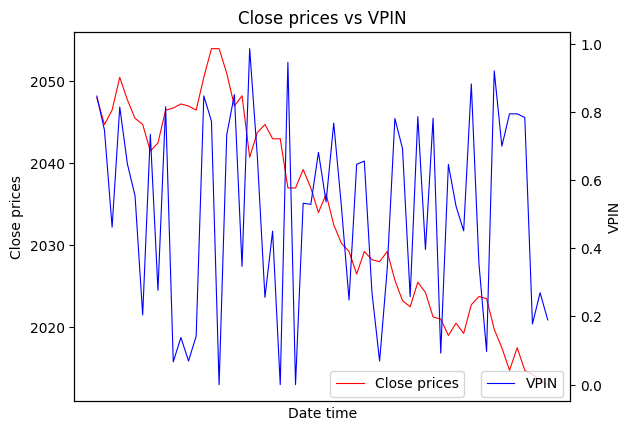

In [17]:
# tale a sub sample to display better.
y_close = data.close[20:80]
y_vpin = vpin[20:80]
index = data.index[20:80]

fig,ax=plt.subplots()
ax.plot(index, y_close , color= 'red',linewidth=0.8,label = 'Close prices')
ax.set_xlabel("Date time")
ax.set_ylabel("Close prices")
plt.title('Close prices vs VPIN')
plt.legend(bbox_to_anchor=(0.8, 0.1))
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(index, y_vpin ,color="blue",linewidth=0.8,label = 'VPIN')
ax2.set_ylabel("VPIN")

ax.tick_params(bottom=False, labelbottom=False)
plt.legend(bbox_to_anchor=(1, 0.1))
plt.show()

From the graph we can see that VPIN fluctuates between values close to one and zero. A number of studies have found that VPIN is a good predictor of volatility.

## Feature Generator <a class="anchor" id="fgen"></a>

Some microstructural features need to be calculated from trades (tick rule/volume/percent change entropies, average tick size, vwap, tick rule sum, trade based lambdas). MlFinLab has a special function which calculates features for generated bars using trade data and bar date_time index.

In [18]:
url = "https://raw.githubusercontent.com/hudson-and-thames/example-data/main/test_tick_data.csv"
df_trades = pd.read_csv(url, parse_dates=[0])
df_trades = df_trades.iloc[:10000] # Take subsample to avoid look-ahead bias
df_trades['log_ret'] = np.log(df_trades.Price / df_trades.Price.shift(1)).dropna()
non_null_log_ret = df_trades[df_trades.log_ret != 0].log_ret.dropna()

# Take unique volumes only
volume_mapping = quantile_mapping(df_trades.Volume.drop_duplicates(), num_letters=10)

returns_mapping = quantile_mapping(non_null_log_ret, num_letters=10)

# Compress bars from ticks
compressed_bars  = get_volume_bars(df_trades, threshold=20, verbose=False)
compressed_bars.set_index('date_time', inplace=True)
compressed_bars.index = pd.to_datetime(compressed_bars.index)
bar_index = compressed_bars.index
tick_number = compressed_bars.tick_num # tick number where bar was formed

gen = MicrostructuralFeaturesGenerator(df_trades, tick_number,
                                       volume_encoding=volume_mapping,
                                       pct_encoding=returns_mapping)
features = gen.get_features(to_csv=False, verbose=False)
display(features)

,date_time,avg_tick_size,tick_rule_sum,vwap,kyle_lambda,kyle_lambda_t_value,amihud_lambda,amihud_lambda_t_value,hasbrouck_lambda,hasbrouck_lambda_t_value,...,tick_rule_entropy_lempel_ziv,tick_rule_entropy_konto,volume_entropy_shannon,volume_entropy_plug_in,volume_entropy_lempel_ziv,volume_entropy_konto,pct_entropy_shannon,pct_entropy_plug_in,pct_entropy_lempel_ziv,pct_entropy_konto
0,2011-07-31 22:38:52.951,5.800000,0.0,1311.663793,33.329909,2.314613,1.713058e-05,2.288292,-7.401798e-04,-0.468869,...,0.800000,1.000000,1.370951,0.811278,0.600000,1.000000,1.521928,1.500000,0.800000,1.000000
1,2011-07-31 22:39:26.084,1.666667,-12.0,1304.575000,0.004167,0.431788,2.447862e-09,0.431751,-2.652634e-07,-0.760863,...,0.333333,0.470764,0.650022,0.684038,0.416667,0.723149,0.413817,0.439497,0.416667,0.674649
2,2011-07-31 22:39:26.801,8.000000,-3.0,1304.500000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.666667,0.500000,1.584963,1.000000,1.000000,1.000000,0.000000,-0.000000,0.666667,0.500000
3,2011-07-31 22:39:51.519,1.615385,-11.0,1304.511905,0.007937,0.627250,4.663786e-09,0.627310,2.420773e-11,0.000051,...,0.384615,1.000000,0.773228,0.413817,0.461538,0.784140,0.773228,0.816689,0.461538,1.000000
4,2011-07-31 22:39:59.606,2.625000,-8.0,1304.500000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.375000,0.498177,1.061278,0.591673,0.500000,1.000000,0.000000,-0.000000,0.375000,0.498177
5,2011-07-31 22:40:11.168,3.142857,-3.0,1304.613636,0.038889,3.986464,2.284857e-08,3.986844,5.907762e-07,0.774708,...,0.428571,0.676107,1.842371,1.918296,0.714286,1.000000,1.378783,1.251629,0.714286,0.676107
6,2011-07-31 22:40:16.182,1.846154,7.0,1304.781250,0.028846,3.207135,1.694158e-08,3.206590,5.715262e-07,1.108352,...,0.461538,1.000000,1.145110,0.816689,0.538462,1.000000,1.145110,0.816689,0.461538,1.000000
7,2011-07-31 22:40:29.478,1.538462,-1.0,1299.962500,197.958333,1.308711,8.291340e-05,0.771582,2.562189e-03,0.410873,...,0.538462,0.921761,1.145110,1.207519,0.461538,1.000000,2.499698,2.584963,0.769231,1.000000
8,2011-07-31 22:40:30.694,2.363636,-9.0,1305.096154,0.017857,5.000000,1.048368e-08,5.000958,6.449394e-07,2.500239,...,0.454545,0.484707,1.491115,1.156780,0.545455,0.795670,0.439497,-0.000000,0.454545,0.484707
9,2011-07-31 22:40:31.576,3.333333,6.0,1305.250000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.500000,0.509440,1.792481,1.921928,0.666667,1.000000,0.000000,-0.000000,0.500000,0.509440


Inter-bar features calculated -  lambdas, entropies, avg_tick_size and vwap

## Conclusion

This notebook describes the third generation model and feature generator implemented in the MlFinLab package.

This third generation model id originally presented in the book "Advances in Financial Machine Learning" by Marcos Lopez De Prado (https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086).

The feature generator method uses trades data and bars index to calculate inter-bar features. 

Key takeaways from the notebook:

   * Third generation are useful because they incorporate sources of uncertainty when calculating variables that help market makers to update quotes dynamically and manage their inventories.


   * MlFinLab has a special function which calculates all the first, second and third generation model features for generated bars using trade data and bar date_time index.


### Refrences
* Lopez de Prado, M. (2018) Advances in Financial Machine Learning. New York, NY: John Wiley & Sons.